In [ ]:
import pandas as pd
import random

from google.colab import drive
drive.mount('/content/drive')

train = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/TP3/parquet/train.parquet")
test = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/TP3/parquet/test.parquet")

random.seed(666)

Mounted at /content/drive


In [ ]:
#SETS DE ENTRENAMIENTO Y VALIDACIÓN

artistas = list(train.artist.unique())
artistas_train = random.sample(artistas, int(len(artistas) * 0.8)) #Divido los unique de artistas en 80% para train.
artistas_validation = list(set(artistas) - set(artistas_train)) #Divido los unique de artistas en 20% para train.

train_set = train[ train['artist'].isin(artistas_train) ] #Genero el set de entrenamiento.
validation_set = train[ train['artist'].isin(artistas_validation) ] #Genero el set de validación

In [ ]:
#ELIMINO FILAS DE VALIDATION CON GÉNEROS QUE NO ESTÁN EN TRAIN

generos_train = list(train_set.genre.unique())
validation_set = validation_set[validation_set.genre.isin(generos_train)]

In [ ]:
#DROPEO COLUMNAS QUE LEAKEAN INFORMACIÓN

train_set.drop(['artist', 'track_name', 'did', 'a_genres'], axis = 1, inplace = True)
validation_set.drop(['artist', 'track_name', 'did', 'a_genres'], axis = 1, inplace = True)
test.drop(['artist', 'track_name', 'did', 'a_genres'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#SEPARO LABELS DE TARGET

x_train_set = train_set.loc[:, train_set.columns != 'genre']
y_train_set = train_set.loc[:, train_set.columns == 'genre']

x_validation_set = validation_set.loc[:, validation_set.columns != 'genre']
y_validation_set = validation_set.loc[:, validation_set.columns == 'genre']

x_test_set = test.loc[:, test.columns != 'genre']
y_test_set = test.loc[:, test.columns == 'genre']

In [ ]:
#Tengo que llenar language (uso el más común) y s-label (promedio)
lenguaje_mas_comun = x_train_set['language'].value_counts().index[0]
s_label_promedio = x_train_set['s-label'].mean()

x_train_set['language'].fillna(lenguaje_mas_comun, inplace = True)
x_train_set['s-label'].fillna(s_label_promedio, inplace = True)
x_train_set['lyric'].fillna('', inplace = True)

x_validation_set['language'].fillna(lenguaje_mas_comun, inplace = True)
x_validation_set['s-label'].fillna(s_label_promedio, inplace = True)
x_validation_set['lyric'].fillna('', inplace = True)

x_test_set['language'].fillna(lenguaje_mas_comun, inplace = True)
x_test_set['s-label'].fillna(s_label_promedio, inplace = True)
x_test_set['lyric'].fillna('', inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


# **ENCODING DE VARIABLES CATEGÓRICAS**
Mode, Time Signature, Key, Language --> One Hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, rango, features, **kwargs):
  ohe = OneHotEncoder(**kwargs)
  train = df[0]
  valid = df[1]
  test = df[2]
  
  encoded_train = ohe.fit_transform(train[features]).todense().astype(int)
  encoded_valid = ohe.transform(valid[features]).todense().astype(int)
  encoded_test = ohe.transform(test[features]).todense().astype(int)

  cols = dict(zip([x for x in range(rango)], ohe.get_feature_names_out()))

  train = train.reset_index().drop(['index'] + features,axis=1).join(pd.DataFrame(encoded_train).rename(columns = cols))
  valid = valid.reset_index().drop(['index'] + features,axis=1).join(pd.DataFrame(encoded_valid).rename(columns = cols))
  test = test.reset_index().drop(['index'] + features,axis=1).join(pd.DataFrame(encoded_test).rename(columns = cols))

  return train, valid, test
  

In [ ]:
#MODE
x_train_set, x_validation_set, x_test_set = OneHotEncoding([x_train_set, x_validation_set, x_test_set], 1, ['mode'], drop = 'first', handle_unknown = 'ignore')

#TIME SIGNATURE
x_train_set, x_validation_set, x_test_set = OneHotEncoding([x_train_set, x_validation_set, x_test_set], 4, ['time_signature'], handle_unknown = 'ignore')

#KEY
x_train_set, x_validation_set, x_test_set = OneHotEncoding([x_train_set, x_validation_set, x_test_set], 12, ['key'], handle_unknown = 'ignore')

#LANGUAGE
x_train_set, x_validation_set, x_test_set = OneHotEncoding([x_train_set, x_validation_set, x_test_set], 13, ['language'], handle_unknown = 'ignore')

In [ ]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

#Agrego features.
x_train_set['lyric_len'] = x_train_set['lyric'].map(lambda x: len(x))
x_train_set['lyric_count'] = x_train_set['lyric'].map(lambda x: len(word_tokenize(x)))

x_validation_set['lyric_len'] = x_validation_set['lyric'].map(lambda x: len(x))
x_validation_set['lyric_count'] = x_validation_set['lyric'].map(lambda x: len(word_tokenize(x)))

x_test_set['lyric_len'] = x_test_set['lyric'].map(lambda x: len(x))
x_test_set['lyric_count'] = x_test_set['lyric'].map(lambda x: len(word_tokenize(x)))

#Dropeo categoría lyric.
x_train_set = x_train_set.reset_index().drop(['index', 'lyric'],axis=1)
x_validation_set = x_validation_set.reset_index().drop(['index', 'lyric'],axis=1)
x_test_set = x_test_set.reset_index().drop(['index', 'lyric'],axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **ENTRENAMIENTO DEL MODELO Y MÉTRICAS**
### Búsqueda de hiper-parámetros
### Score para validación y test

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import top_k_accuracy_score

modelo = LogisticRegression(random_state = 666)
hiper_parametros = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'dual': [True, False], 'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 'C': [0.1, 0.5, 1, 1.2, 1.5], 
                    'fit_intercept': [True, False], 'intercept_scaling' : [0.1, 0.5, 1, 1.5, 2, 5, 10],  'class_weight' : ['balanced', None], 
                    'solver': ['newton-cg', 'liblinear', 'saga', "lbfgs"], 'multi_class': ['auto', 'ovr', 'multinomial']}

random_search = RandomizedSearchCV(modelo, hiper_parametros, random_state = 666, n_iter = 150)
search = random_search.fit(x_train_set, y_train_set)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearc

In [ ]:
modelo_tuneado = random_search.best_estimator_

proba_preds_valid = modelo_tuneado.predict_proba(x_validation_set)
top_k_accuracy_valid = top_k_accuracy_score(y_validation_set, proba_preds_valid, k = 2, labels = modelo_tuneado.classes_)
print("El score con el set de validación es", top_k_accuracy_valid)

proba_preds_test = modelo_tuneado.predict_proba(x_test_set)
top_k_accuracy_test = top_k_accuracy_score(y_test_set, proba_preds_test, k = 2, labels = modelo_tuneado.classes_)
print("El score con el set de pruebas es", top_k_accuracy_test)

El score con el set de validación es 0.48406699273751297
El score con el set de pruebas es 0.5216655382532159


###CSV de las predicciones obtenidas para test.

In [ ]:
predict_probas_test = x_test_set.join(pd.DataFrame(proba_preds_test, columns = modelo_tuneado.classes_))
predict_probas_test.to_csv('predict_test_baseline.csv')
!cp predict_test.csv "/content/drive/MyDrive/Colab Notebooks/TP3"

###Feature Importance
Queremos la suma de las columnas de la matriz de coeficientes en valor absoluto, dividida por el promedio de cada feature.

Text(0.5, 0, 'Feature')

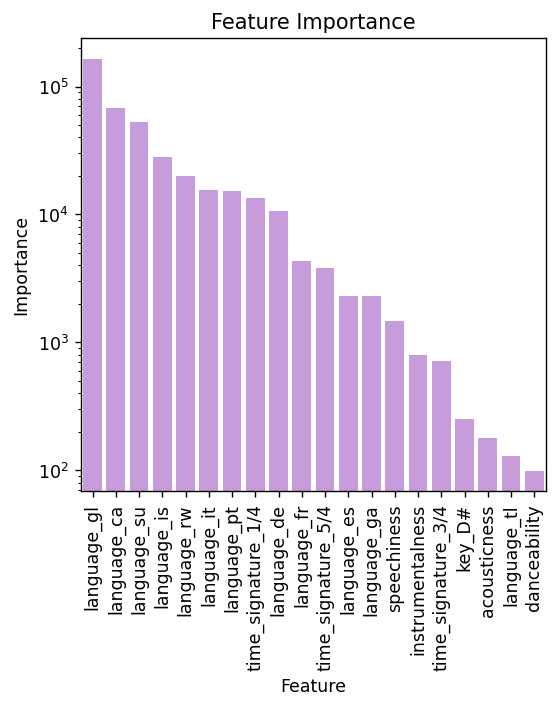

In [ ]:
weight = pd.DataFrame(abs(modelo_tuneado.coef_).sum(axis = 0), columns = ['weight'])
feature = pd.DataFrame(x_test_set.columns, columns = ['feature'])
feature_mean = x_train_set.mean().to_frame().reset_index().rename(columns = {'index' : 'feature', 0: 'mean'})
feature_weight = feature.join(weight).sort_values(by = ['weight'], ascending = False)

feature_importance = pd.merge(feature_weight, feature_mean, on = 'feature', how = 'outer')
feature_importance['importance'] = feature_importance['weight'] / feature_importance['mean']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(dpi=125,figsize=(4.8, 4.8))
sns.barplot(data = feature_importance.sort_values(by = ['importance'], ascending = False).head(20), x = 'feature', y = 'importance', palette=['#cb92e5'])
plt.xticks(rotation = 90)
plt.yscale('log')
plt.title("Feature Importance")
plt.ylabel('Importance')
plt.xlabel('Feature')